In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_processor_pipeline.cleaner import *
from data_processor_pipeline.custom_dataset import *
from metrics.plot_confusion_matrix import plot_cfs_matrix
from datasets import load_dataset
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

# Data_Preprocess

## Read data and cleaning

In [2]:
data=pd.read_csv('vietnamese_student_feedbacks.csv', encoding='utf-8-sig')
data_processor=data_clean()
data['sentence']=data['sentence'].map(lambda x: data_processor.clean_text(x))

## Train_validation_test

In [3]:
from sklearn.model_selection import train_test_split

data['combined_label']=list(zip(data["sentiment"], data['topic']))
X_train, X_test, y_train, y_test = train_test_split(data['sentence'].reset_index(drop=True).to_list(),
                                                    data['combined_label'].reset_index(drop=True).to_list(),
                                                    test_size=0.1,
                                                    stratify=data['topic'],
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [4]:
len(X_train), len(X_val), len(X_test)

(13101, 1456, 1618)

In [5]:
y_train_sentiment, y_train_topic = zip(*y_train)
y_val_sentiment, y_val_topic = zip(*y_val)
y_test_sentiment, y_test_topic = zip(*y_test)

## Resampled

In [ ]:
df_y_train_sentiment = pd.DataFrame(y_train_sentiment, columns=['y_train_sentiment'])

In [7]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==1].to_numpy().flatten()
oversample_size = df_y_train_sentiment[df_y_train_sentiment['y_train_sentiment']==0].shape[0] - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([y_train_sentiment, np.array([1] * oversample_size)], axis=0)

In [8]:
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

## Create dataLoader

## Sentiment

In [6]:
train_dataset_sentiment=Custom_Dataset(X_train, torch.tensor(y_train_sentiment, dtype=torch.long), file_path='vocab.pkl', is_save_vocab=False)
val_dataset_sentiment=Custom_Dataset(X_val, y_val_sentiment, file_path='vocab.pkl', is_save_vocab=False, max_length=train_dataset_sentiment.max_length)
test_dataset_sentiment=Custom_Dataset(X_test, y_test_sentiment, file_path='vocab.pkl', is_save_vocab=False, max_length=train_dataset_sentiment.max_length)

In [12]:
train_loader_sentiment=DataLoader(train_dataset_sentiment, batch_size=16, shuffle=True)
val_loader_sentiment=DataLoader(val_dataset_sentiment, batch_size=16, shuffle=True)
test_loader_sentiment=DataLoader(test_dataset_sentiment, batch_size=16, shuffle=True)

# DL_model for sentiment classification

## RNN

### Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_rnn import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *

In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_RNN=RNN(vocab_size=5000, embedding_dim=128, num_layers=1, activation=nn.ReLU(), batch_normalization=True, bidirectional=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_RNN=optim.Adam(model_RNN.parameters(), lr=0.01)
epochs=5
trainer=trainer()
log_dir='logs/RNN'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer=SummaryWriter(log_dir='logs/RNN')
print(model_RNN)

RNN(
  (embedding): Embedding(5000, 128)
  (rnn): RNN(128, 64, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [ ]:
best_Acc_RNN=0
for epoch in range(epochs):
    trainer.train(model_RNN, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_RNN, device)
    val_loss, val_acc = trainer.validation(model_RNN, val_loader_sentiment, criterion, device)
    print(f"VALIDATION | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_RNN.state_dict(),
        'epoch': epoch+1,
        'optimizer_state_dict': optimizer_RNN.state_dict()
    }
    os.makedirs('model/RNN', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/RNN', 'last.pt'))
    if val_acc>best_Acc_RNN:
        torch.save(checkpoint, os.path.join('model/RNN', 'best.pt'))
        best_Acc_RNN=val_acc

## GRU

### Training

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from build_model.build_gru import *
from torch.utils.tensorboard import SummaryWriter
from training.trainer import *

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False).to(device)
criterion=nn.CrossEntropyLoss()
optimizer_GRU=optim.Adam(model_GRU.parameters(), lr=0.001)
epochs=5
trainer=trainer()
log_dir='logs/GRU'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir=log_dir)
print(model_GRU)

GRU(
  (embedding): Embedding(5000, 128)
  (gru): GRU(128, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=64, out_features=3, bias=True)
)


In [28]:
best_acc=0
for epoch in range(epochs):
    trainer.train(model_GRU, train_loader_sentiment, epoch, epochs, writer, criterion, optimizer_GRU, device)
    val_loss, val_acc = trainer.validation(model_GRU, val_loader_sentiment, criterion, device)
    print(f"TEST | Epoch: {epoch+1}/{epochs} | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    writer.add_scalar('Val/Loss', val_loss, epoch+1)
    writer.add_scalar('Val/Acc', val_acc, epoch+1)
    checkpoint = {
        'model_state_dict': model_GRU.state_dict(),
        'epoch': epoch+1,
        'opimizer_state_dict': optimizer_GRU.state_dict(),
    }
    os.makedirs('model/GRU', exist_ok=True)
    torch.save(checkpoint, os.path.join('model/GRU','last.pt'))
    if val_acc>best_acc:
        torch.save(checkpoint, os.path.join('model/GRU','best.pt'))
        best_acc=val_acc

TRAIN | Epoch: 1/5 | Iter: 1160/1160 | Error: 0/1160 | Loss: 0.0219: 100%|██████████| 1160/1160 [00:53<00:00, 21.64it/s]


TEST | Epoch: 1/5 | Loss: 0.0188 | Accuracy: 0.8915


TRAIN | Epoch: 2/5 | Iter: 1160/1160 | Error: 0/1160 | Loss: 0.0137: 100%|██████████| 1160/1160 [00:59<00:00, 19.40it/s]


TEST | Epoch: 2/5 | Loss: 0.0177 | Accuracy: 0.9093


TRAIN | Epoch: 3/5 | Iter: 1160/1160 | Error: 0/1160 | Loss: 0.0106: 100%|██████████| 1160/1160 [01:00<00:00, 19.21it/s]


TEST | Epoch: 3/5 | Loss: 0.0196 | Accuracy: 0.9114


TRAIN | Epoch: 4/5 | Iter: 1160/1160 | Error: 0/1160 | Loss: 0.0088: 100%|██████████| 1160/1160 [01:00<00:00, 19.09it/s]


TEST | Epoch: 4/5 | Loss: 0.0202 | Accuracy: 0.9148


TRAIN | Epoch: 5/5 | Iter: 1160/1160 | Error: 0/1160 | Loss: 0.0072: 100%|██████████| 1160/1160 [01:01<00:00, 18.88it/s]


TEST | Epoch: 5/5 | Loss: 0.0199 | Accuracy: 0.9128


### Evaluate


In [29]:
from training.trainer import *
from build_model.build_gru import *
trainer=trainer()
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GRU=GRU(vocab_size=5000, embedding_dim=128, num_layers=2, activation=None, batch_normalization=True, bidirectional=False).to(device)
model_state_dict=torch.load('model/GRU/best.pt', map_location=device)
model_GRU.load_state_dict(model_state_dict['model_state_dict'])
result_GRU_on_test=trainer.evaluate(model_GRU, test_loader_sentiment, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [30]:
result_GRU_df=pd.DataFrame({
    'accuracy': result_GRU_on_test['accuracy'],
    'precision': result_GRU_on_test['precision'],
    'recall': result_GRU_on_test['recall'],
    'f1-score': result_GRU_on_test['f1-score']
}, index=['GRU'])
result_GRU_df

,accuracy,precision,recall,f1-score
GRU,0.914091,0.932634,0.914091,0.921216


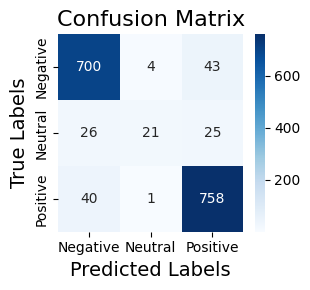

In [31]:
plot_cfs_matrix(result_GRU_on_test['confusion_matrix'], ["Negative", "Neutral", "Positive"])

### HyperParameters Tuning

In [10]:
from SearchCV.randomizedSearchCv_GRU import *

In [7]:
from SearchCV.perform_randomSearch import *

In [8]:
from scipy.stats import randint, uniform  # Import these for param_dist
param_dist = {
    'embedding_dim': randint(128, 256),
    'num_layers': randint(1, 3),
    'drop_out': uniform(0.2, 0.5),
    'units':  randint(64, 128),
    'activation': [None],
    'batch_normalization': [True, False],
    'bidirectional': [True, False],
    'lr': uniform(0.0001, 0.01),
    'epochs': randint(3, 5)
}

In [11]:
model_wrapper = PytorchModelWrapper(vocab_size=5000, embedding_dim=128, num_layers=2,
                                    drop_out=0.2,
                                    units=64,
                                    activation=None, 
                                    batch_normalization=True,
                                    bidirectional=False)

In [13]:
best_params, best_model = perform_random_search_pytorch('GRU', model_wrapper, param_dist,
                                                        train_dataset_sentiment[:]['numericalized_encode'],
                                                        train_dataset_sentiment[:]['labels'],
                                                        n_iter=1,
                                                        cv=2)


GRU model results after HyperParameters Tuning:

Params: {'activation': None, 'batch_normalization': False, 'bidirectional': False, 'drop_out': 0.43213670417397704, 'embedding_dim': 196, 'epochs': 4, 'lr': 0.008929428540843271, 'num_layers': 2, 'units': 110} - Mean test score: 0.89 - Rank: 1

Bests parameters for GRU model: {'activation': None, 'batch_normalization': False, 'bidirectional': False, 'drop_out': 0.43213670417397704, 'embedding_dim': 196, 'epochs': 4, 'lr': 0.008929428540843271, 'num_layers': 2, 'units': 110}

